In [1]:
#mount google drive when on google colaboratory

from google.colab import drive
drive.mount('/content/drive')

#set repo path and check repo status
repo_path = '/content/drive/MyDrive/music_speech/'
%cd /content/drive/MyDrive/music_speech/
!git status

Mounted at /content/drive
/content/drive/MyDrive/music_speech
Refresh index: 100% (3/3), done.
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [6]:
#initialize environment, load modules/libraries

import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from scipy.signal import hann
from scipy.io import wavfile


#import python code from seperate files
from helpers.fourier_transform import load_wav, dft, idft, get_mag_phs


In [7]:
music_dir = './data/music_wav'
music = [os.path.join(music_dir, file_i) for file_i in os.listdir(music_dir) if file_i.endswith('.wav')]

speech_dir = './data/speech_wav'
speech = [os.path.join(speech_dir, file_i) for file_i in os.listdir(speech_dir) if file_i.endswith('.wav')]
		  
print (len(music), len(speech))

64 64


(661500,)


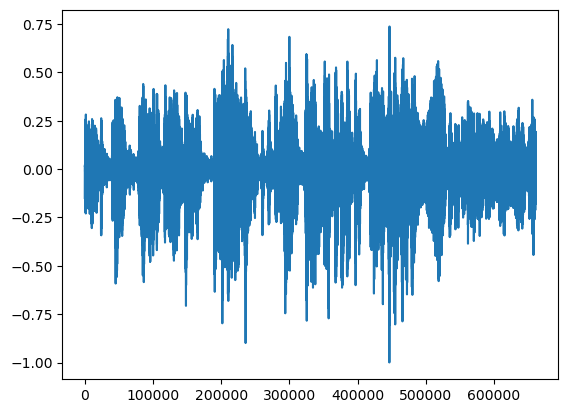

(256, 2583)


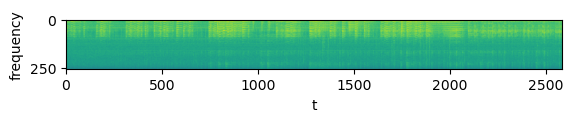

In [10]:
mus0 = load_wav(music[10])
print(mus0.shape)
plt.plot(mus0)
plt.show()

re, im = dft(mus0)
mag, phs = get_mag_phs(re, im)
mag = mag.T #transpose
magl = np.log(mag)
print(mag.shape)
plt.imshow(magl)
plt.xlabel('t')
plt.ylabel('frequency')
plt.show()